In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



class my_linear_regression(object):
    def __init__(self,df:pd.DataFrame):
        '''
        传入的是训练集
        假设最后一列是目标列
        '''
        self.df=df
        self.x=self._get_x()
        self.y=self._get_y()
        
        # self._normalize()#! 如果想更改原来的数据 那么也可以直接self.df=normalize_feature(self.df)
        
    def normalize(self):
        '''
        归一化
        :param X:
        :return:
        '''
        mu = np.mean(self.x, axis=0)
        # ddof的设置，会改变标准差的结算结果，因为总体误差和样本误差的计算公式不一样
        #标准差
        sigma = np.std(self.x, axis=0, ddof=1)
        
        self.mu=mu
        self.sigma=sigma
        
        
        #! 为了不出现nan
        for i in range(len(sigma)):
            if sigma[i]==0:
                sigma[i]=1
                
        x_norm = (self.x-mu)/ sigma


        
        #todo 加为1的特征
        ones = np.ones((x_norm.shape[0], 1))
        x_norm=np.c_[ones,x_norm]
        
        self.x_norm=x_norm

        self.untrained_theta = np.zeros((self.x_norm.shape[1],1))
        self.alpha=0.01
        
    
    def _get_x(self)->np.ndarray: 
        '''
        获取特征列
        '''
        return self.df.iloc[:, 0:-1].values  # 这个操作获取所有的特征列(即排除了target列)，返回 ndarray,不是矩阵
    
    def _get_y(self)->np.ndarray:
        """
        假设最后一列是目标列
        获取目标列

        """
        #! 与[:,-1]不同！#!!!!!!!!!!!!!!!!!!!!!!!
        
        return self.df.iloc[:,len(self.df.columns)-1 :len(self.df.columns)].values # df.iloc[:, -1]是指df的最后一列
    
    def _lr_cost(self,theta, x: np.ndarray, y: np.ndarray):
        '''
        可主动调用这个函数，传入未知数向量
        可用于在测试集上对模型进行评估 (使用均方误差)
        param theta: 维度是R(n)，是线性回归的参数
        param x: 维度是R(m*n)，m为样本数，n为特征数
        param y:维度是R(m)
        return: cost
        '''
        m = x.shape[0]  # m为样本数
        # 计算每个样本的每个特征与对应参数的乘积
        inner = x.dot(theta) - y  # x.dot(theta)等价于np.dot(x,theta)，inner的维度是R(m*1)

        square_sum = np.dot(inner.T, inner)#! 等号右侧其实就是计算了平方的和
        
        cost = square_sum / (2 * m)
        return cost[0][0]
    

    def _gradient(self,theta, x:np.ndarray, y: np.ndarray):
        '''
        :param theta: 维度是R(n)，是线性回归的参数
        :param x: 维度是R(m*n)，m为样本数，n为特征数
        :param y: 维度是R(m)
        :return:维度是R(n+1,1)，即与参数向量theta同维度
        '''
        m = x.shape[0]
        inner = np.dot(x.T, (np.dot(x, theta) - y))#dot中第二个参数是差值向量
        return inner / m

    # 批量梯度下降函数
    def _batch_gradient_decent(self,theta, x, y, epoch, alpha):
        '''
        :param theta: 维度是R(n)，是线性回归的参数
        :param X: 维度是R(m*n)，m为样本数，n为特征数
        :param y: 维度是R(m)
        :param epoch: 处理的轮数
        :param alpha: 学习率，即梯度下降更新公式里的alpha
        :return: 拟合线性回归,返回最终的未知数向量和每次的误差
        '''
    
        cost_data = [self._lr_cost(theta, x, y)]#! 记录每次移动之后的代价值 我们目的是通过可视化 来找到最小的cost所对应的theta
        _theta = theta.copy()  # 拷贝一份，不和原来的theta混淆

        for _ in range(epoch):

            
            #! 公式
            _theta = _theta - alpha * self._gradient(_theta, x, y)
            
            #! 记录cost
            cost_data.append(self._lr_cost(_theta, x, y))

        return _theta, cost_data
    
    
    def show_to_choose_alpha(self,epoch=50):
        '''
        step1 通过观察图像选择较好的学习率
        (可省略此步骤，若省略则使用默认的0.01学习率)
        ''' 
        
        # 产生不同的学习率
        base = np.logspace(-1, -5, num=4) #指定起始及结束值，并指定个数，默认以10为底。该方法的详细用法见参考文章
        # print(base)
        candidate = np.sort(np.concatenate((base, base*3)))
        # print(candidate)


        fig, ax = plt.subplots(figsize=(16, 9)) # 生成画布
        # 遍历每一个学习率
        for alpha in candidate:
            # 使用当前学习率拟合数据，计算迭代过程中的代价值
            _, cost_data = self._batch_gradient_decent(self.untrained_theta, self.x_norm, self.y, epoch, alpha)
            # 绘制当前学习率之下的代价值的变化情况
            ax.plot(np.arange(epoch+1), cost_data, label=alpha)

        ax.set_xlabel('epoch', fontsize=18)
        ax.set_ylabel('cost', fontsize=18)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_title('learning rate', fontsize=18)
        plt.show()
        
        self.alpha=eval(input('请输入选择的学习率:'))
            
    
    def train(self,epoch=500):
        '''
        step2:训练模型 
        
        epoch:训练次数
        alpha:学习率
        默认训练500次
        学习率0.01
        返回最终未知数向量(第一个分量为常数的值)
        '''
        
        self.final_theta,self.cost_data= self._batch_gradient_decent(self.untrained_theta,self.x_norm,self.y,epoch,self.alpha)
        
        return self.final_theta,self.cost_data#! 是为了给调用者看的
    
    def model_check(self,test_data:pd.DataFrame):
        '''
        传入测试集并汇报均方误差
        '''
        _=my_linear_regression(test_data)
        
        _.normalize()
        
        return (self._lr_cost(self.final_theta,_.x_norm,_.y))
        
    
    def show_training_process(self):


        # final_theta,cost_data=self.get_result(epoch,alpha)
        #! 为了防止重复调用 直接变成属性
        print('学习率为:',self.alpha)
        print('最终的系数向量即final_theta为(第一个数是截距):',self.final_theta)
        # final_theta 即为结果 查看最终的参数向量值（由于特征超过两个，就无法用二维平面图来直观查看拟合的曲线了）        
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.plot(range(len(self.cost_data)),self.cost_data)#! 已知x y轴 进行画曲线图
        plt.show()   
        
#这里要注意路径中的斜杠,和我们从文件属性中复制出来的方向不一致。

    def predict(self,df: pd.DataFrame):
        # arr=(arr-self.mu)/self.sigma
        
        # arr = np.concatenate((np.ones((1,)), arr))
        temp=my_linear_regression(df)
        temp.normalize()
        result = temp.x_norm.dot(self.final_theta)
        print('预测结果为:',result)
        print('真实的结果为:',temp.y)
        
    

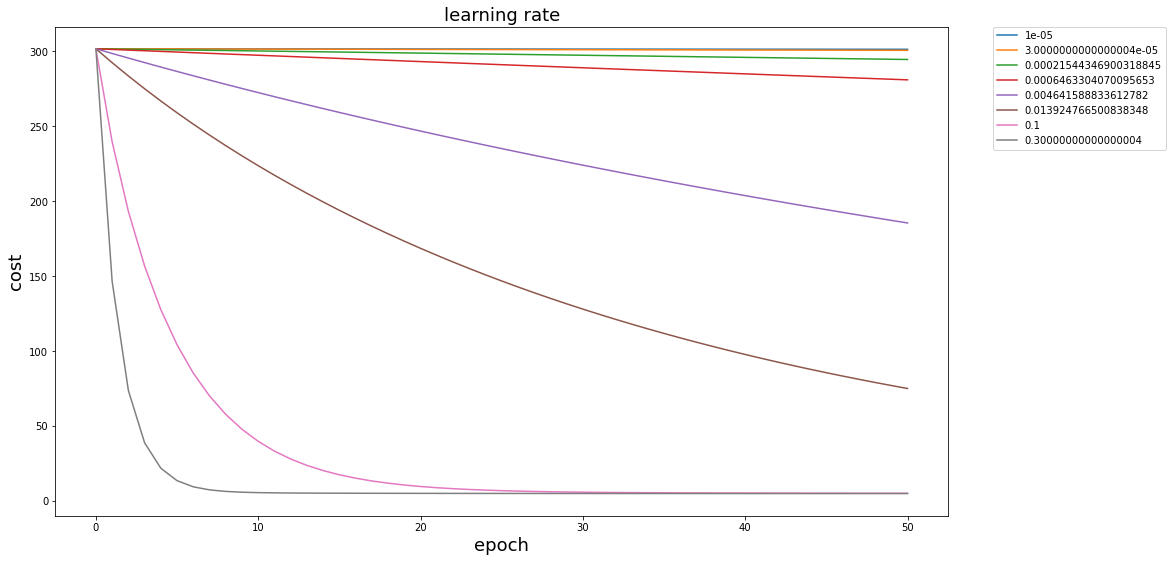

学习率为: 0.3
最终的系数向量即final_theta为(第一个数是截距): [[ 2.32610000e+01]
 [ 9.61317313e-01]
 [ 5.13577560e-01]
 [ 2.89656829e-02]
 [ 2.85656816e-03]
 [-8.75092112e-01]
 [ 5.33949042e+00]
 [-1.10411645e+00]
 [-2.14280240e+00]
 [ 6.04518401e-01]
 [-1.35809053e+00]
 [-1.60047569e+00]
 [ 9.71589777e-01]
 [-1.20184319e+00]]


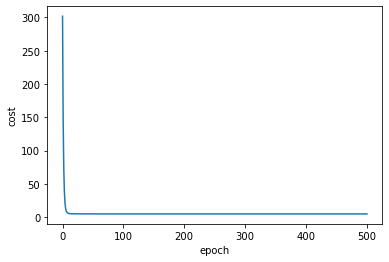

模型在测试集上均方误差为: 27.068339173997575
预测结果为: [[31.14396179]
 [27.60788827]
 [37.79440296]
 [35.24615834]
 [36.21087998]
 [27.81432532]
 [21.79595746]
 [20.06668901]
 [11.37177228]
 [17.28021836]
 [21.32546437]
 [19.311967  ]
 [21.39196516]
 [20.40603253]
 [20.35116594]
 [19.80767251]
 [23.59189893]
 [19.70083276]
 [13.86104019]
 [19.13970684]]
真实的结果为: [[24. ]
 [21.6]
 [34.7]
 [33.4]
 [36.2]
 [28.7]
 [22.9]
 [27.1]
 [16.5]
 [18.9]
 [15. ]
 [18.9]
 [21.7]
 [20.4]
 [18.2]
 [19.9]
 [23.1]
 [17.5]
 [20.2]
 [18.2]]


In [5]:
data=pd.read_csv('boston.csv')

data_train=data[:200].copy()

my_lr=my_linear_regression(data_train)

my_lr.normalize()

#! 看图找到合适的学习率
my_lr.show_to_choose_alpha()

#! 训练
my_lr.train()

#! 输出训练结果
my_lr.show_training_process()


#! 预测模型在测试集合上的准确率
result=my_lr.model_check(data[200:400].copy())
print('模型在测试集上均方误差为:',result)


print('===============================================')
#! 传入数据 输出预测值

my_lr.predict(data[:20].copy())


In [6]:
from sklearn.decomposition import PCA



for x in range(1,14):
    data_temp=data.copy()
    pca=PCA(n_components=x)
    a=my_linear_regression(data_temp)
    pca.fit(a.x)
    a.x=pca.transform(a.x)
    
    a.normalize()
    a.train()
    cost=a._lr_cost(a.final_theta,a.x_norm,a.y)
    
    print(cost)
        

# print(best_x,score)

32.21122974341788
31.97191626688672
30.077368554529055
29.841846447465425
28.412915079186945
17.835599330904365
17.413259843967996
16.846037475648664
14.354932314968249
13.517344338435233
11.62174032091705
11.441394642810074
10.959752050297823
